<a href="https://colab.research.google.com/github/mighty-mass/ai-engineer-course/blob/main/DeepLearning/VisionTechSolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Riconoscimento di animali per auto a guida autonoma
VisionTech Solutions vuole sviluppare un sistema di riconoscimento automatico delle immagini per distinguere tra veicoli e animali, con l'obiettivo di ottimizzare le operazioni di monitoraggio della fauna nelle aree urbane, evitando incidenti stradali e proteggendo sia gli animali che i veicoli.

VisionTech Solutions collabora con le amministrazioni comunali per implementare un sistema di monitoraggio in tempo reale nelle città, utilizzando telecamere installate lungo le strade per identificare e classificare veicoli e animali. Questo sistema aiuterà a prevenire incidenti stradali causati dall'attraversamento improvviso di animali, avvisando i guidatori tramite segnali stradali elettronici.

Benefici:

1. Automazione dei Processi:
- Riduzione del tempo e delle risorse per monitorare manualmente le aree urbane.
- Rilevamento automatico e in tempo reale di animali e veicoli.
2. Aumento della Precisione:
- Utilizzo di una rete neurale convoluzionale (CNN) per garantire alta precisione nella classificazione delle immagini.
- Minimizzazione degli errori umani.
3. Efficienza Operativa:
- Processamento rapido e accurato di grandi volumi di dati, migliorando la risposta agli eventi.
- Maggiore sicurezza per i cittadini e riduzione dei danni ai veicoli.
4. Applicazioni Multiple:
- Sorveglianza e monitoraggio del traffico.
- Analisi del comportamento animale nelle aree urbane.
- Utilizzo dei dati per migliorare le politiche di sicurezza stradale.

## Dettagli del Progetto:

1. Dataset:
- Utilizzo del dataset CIFAR, contenente migliaia di immagini etichettate in varie categorie, inclusi veicoli e animali.
2. Algoritmo:
- Implementazione di una rete neurale convoluzionale (CNN) per l'analisi e la classificazione delle immagini.
3. Output:
- Il sistema classificherà correttamente ogni immagine come veicolo o animale.

## Valutazione del Modello:

- **Accuratezza**: Proporzione di immagini classificate correttamente rispetto al totale.
- **Precisione**: Qualità delle predizioni positive, indicando la proporzione di immagini correttamente identificate.

## Analisi dei Risultati:

- Identificazione di eventuali pattern di errore.
- Valutazione delle categorie di immagini confuse sistematicamente.
- Esame delle immagini errate e riflessione su possibili migliorie al modello.

## Risultato Finale:

- Presentazione completa della rete neurale convoluzionale e delle sue capacità di discriminazione tra veicoli e animali.
- Discussione dettagliata delle metriche utilizzate e un'analisi critica delle prestazioni e limitazioni del modello.

Questo progetto fornirà a VisionTech Solutions un sistema efficace per migliorare la sicurezza stradale e la gestione della fauna nelle aree urbane, dimostrando le competenze pratiche nell'applicazione del machine learning al riconoscimento delle immagini.

#1. Carichiamo tutte le librerie necessarie

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import Image
import seaborn as sns
import pandas as pd
import os
import time

# 2. Preparazione del dataset

Carichiamo il dataset CIFAR-10 e lo adattiamo al nostro problema binario: veicoli (aereo, automobile, nave, camion) vs animali (uccello, gatto, cervo, cane, rana, cavallo).

Le classi di CIFAR-10 sono:
* 0: aereo
* 1: automobile
* 2: uccello
* 3: gatto
* 4: cervo,
* 5: cane
* 6: rana
* 7: cavallo
* 8: nave
* 9: camion
    
Mappiamo le classi originali a classi binarie:
- Veicoli (0): aereo (0), automobile (1), nave (8), camion (9)
- Animali (1): uccello (2), gatto (3), cervo (4), cane (5), rana (6), cavallo (7)

In [2]:
def load_and_prepare_cifar10():
    print("Caricamento e preparazione del dataset CIFAR-10...")
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    class_mapping = {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0}
    y_train_binary = np.array([class_mapping[y[0]] for y in y_train])
    y_test_binary = np.array([class_mapping[y[0]] for y in y_test])
    x_train, x_val, y_train_binary, y_val_binary = train_test_split(
        x_train, y_train_binary, test_size=0.2, random_state=42, stratify=y_train_binary
    )
    x_train = x_train.astype('float32') / 255.0
    x_val = x_val.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    y_train_binary = to_categorical(y_train_binary, 2)
    y_val_binary = to_categorical(y_val_binary, 2)
    y_test_binary = to_categorical(y_test_binary, 2)
    class_names = ['Veicolo', 'Animale']
    print(f"Train: {x_train.shape}, Validation: {x_val.shape}, Test: {x_test.shape}")
    return (x_train, y_train_binary), (x_val, y_val_binary), (x_test, y_test_binary), class_names

# load_and_prepare_cifar10()

# 3. Data augmentation

Per migliorare la generalizzazione del modello, applichiamo tecniche di data augmentation alle immagini di training.

Nel nostro caso applichiamo le seguenti trasformazioni all'immagine:
- Rotazioni casuali
- Traslazioni orizzontali e verticali
- Shearing (taglio)
- Zoom
- Ribaltamento orizzontale
- Riempimento dei pixel vuoti con il valore più vicino

In [3]:
def create_data_generators(x_train, y_train):
    print("Creazione dei generatori di dati con data augmentation...")
    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    return train_datagen.flow(x_train, y_train, batch_size=32)

def visualize_augmented_samples(x_train, y_train, class_names):
    print("Visualizzazione di esempi di data augmentation...")
    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    sample_images = x_train[:5]
    sample_labels = y_train[:5]
    aug_iter = train_datagen.flow(sample_images, sample_labels, batch_size=1)
    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(sample_images[i])
        plt.title(f"Orig: {class_names[np.argmax(sample_labels[i])]}")
        plt.axis('off')
        aug_img = next(aug_iter)[0][0]
        plt.subplot(2, 5, i+6)
        plt.imshow(aug_img)
        plt.title("Aumentata")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('data_augmentation_examples.png')
    plt.close()
    print("Esempi di data augmentation salvati in 'data_augmentation_examples.png'")

In [4]:
# Impostiamo la riproducibilità
np.random.seed(42)
tf.random.set_seed(42)

(x_train, y_train), (x_val, y_val), (x_test, y_test), class_names = load_and_prepare_cifar10()
train_generator = create_data_generators(x_train, y_train)
visualize_augmented_samples(x_train, y_train, class_names)

Caricamento e preparazione del dataset CIFAR-10...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Train: (40000, 32, 32, 3), Validation: (10000, 32, 32, 3), Test: (10000, 32, 32, 3)
Creazione dei generatori di dati con data augmentation...
Visualizzazione di esempi di data augmentation...
Esempi di data augmentation salvati in 'data_augmentation_examples.png'


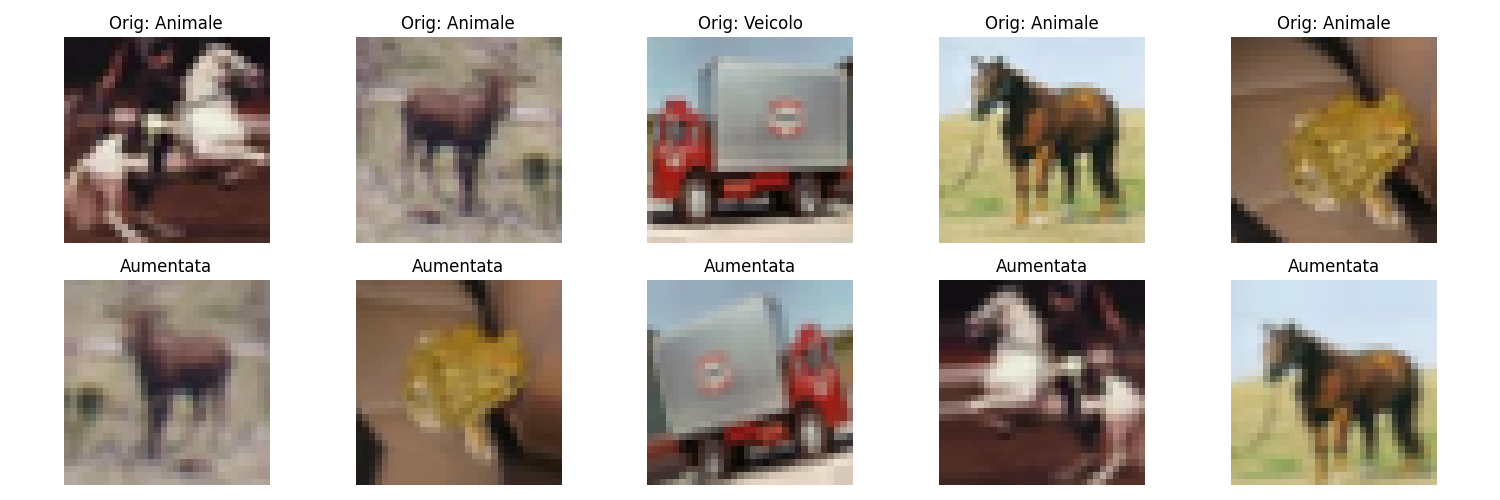

In [5]:
Image('data_augmentation_examples.png')

# 4. Definizione e addestramento della CNN

In questa sezione definiamo la struttura della rete neurale convoluzionale e la addestriamo sui dati preparati.

Estimated runtime: ~8700 seconds (~2h 20m)


In [6]:
def create_cnn_model(input_shape=(32, 32, 3), conv_blocks=[(32, 0.2), (64, 0.3), (128, 0.4)], dense_units=256, dense_dropout=0.5):
    print("Creazione del modello CNN...")
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for filters, dropout in conv_blocks:
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(dropout)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dense_dropout)(x)
    outputs = layers.Dense(2, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="vehicle_animal_classifier")
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def train_model(model, train_generator, x_val, y_val, epochs=20):
    print("Inizio addestramento del modello...")
    checkpoint_filepath = 'best_model_vehicle_animal.keras'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001
    )
    start_time = time.time()
    steps_per_epoch = len(train_generator)
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=[model_checkpoint_callback, early_stopping, reduce_lr]
    )
    training_time = time.time() - start_time
    print(f"Addestramento completato in {training_time:.2f} secondi")
    if os.path.exists(checkpoint_filepath):
        print(f"Caricamento del miglior modello da: {checkpoint_filepath}")
        model = keras.models.load_model(checkpoint_filepath)
    return model, history

def visualize_training_history(history):
    print("Visualizzazione dell'andamento dell'addestramento...")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuratezza del Modello')
    plt.ylabel('Accuratezza')
    plt.xlabel('Epoca')
    plt.legend(loc='lower right')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss del Modello')
    plt.ylabel('Loss')
    plt.xlabel('Epoca')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()
    print("Grafici di addestramento salvati in 'training_history.png'")

start = time.time()
model = create_cnn_model()
trained_model, history = train_model(model, train_generator, x_val, y_val)
visualize_training_history(history)
print(f"Tempo totale di addestramento: {time.time() - start:.2f} secondi")

Creazione del modello CNN...


Model: "vehicle_animal_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,02

 Total params: 814,882 (3.11 MB)

 Trainable params: 813,474 (3.10 MB)

 Non-trainable params: 1,408 (5.50 KB)

Inizio addestramento del modello...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.8280 - loss: 0.4536

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 436s 343ms/step - accuracy: 0.8281 - loss: 0.4535 - val_accuracy: 0.9057 - val_loss: 0.2399 - learning_rate: 0.0010
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.8944 - loss: 0.2586

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 426s 341ms/step - accuracy: 0.8944 - loss: 0.2586 - val_accuracy: 0.9168 - val_loss: 0.2188 - learning_rate: 0.0010
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9093 - loss: 0.2288

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 424s 326ms/step - accuracy: 0.9093 - loss: 0.2288 - val_accuracy: 0.9367 - val_loss: 0.1621 - learning_rate: 0.0010
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 447s 330ms/step - accuracy: 0.9170 - loss: 0.2101 - val_accuracy: 0.9347 - val_loss: 0.1687 - learning_rate: 0.0010
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 430s 344ms/step - accuracy: 0.9242 - loss: 0.1985 - val_accuracy: 0.9348 - val_loss: 0.1763 - learning_rate: 0.0010
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9303 - loss: 0.1770

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 400s 310ms/step - accuracy: 0.9303 - loss: 0.1770 - val_accuracy: 0.9379 - val_loss: 0.1709 - learning_rate: 0.0010
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9365 - loss: 0.1622

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 442s 311ms/step - accuracy: 0.9365 - loss: 0.1622 - val_accuracy: 0.9559 - val_loss: 0.1186 - learning_rate: 5.0000e-04
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 441s 310ms/step - accuracy: 0.9403 - loss: 0.1540 - val_accuracy: 0.9354 - val_loss: 0.1659 - learning_rate: 5.0000e-04
Epoch 9/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 388s 310ms/step - accuracy: 0.9435 - loss: 0.1483 - val_accuracy: 0.9536 - val_loss: 0.1222 - learning_rate: 5.0000e-04
Epoch 10/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 442s 310ms/step - accuracy: 0.9464 - loss: 0.1401 - val_accuracy: 0.9466 - val_loss: 0.1372 - learning_rate: 5.0000e-04
Epoch 11/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9492 - loss: 0.1324

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 387s 309ms/step - accuracy: 0.9492 - loss: 0.1324 - val_accuracy: 0.9633 - val_loss: 0.0980 - learning_rate: 2.5000e-04
Epoch 12/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 408s 326ms/step - accuracy: 0.9526 - loss: 0.1231 - val_accuracy: 0.9545 - val_loss: 0.1221 - learning_rate: 2.5000e-04
Epoch 13/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 389s 311ms/step - accuracy: 0.9525 - loss: 0.1264 - val_accuracy: 0.9614 - val_loss: 0.0986 - learning_rate: 2.5000e-04
Epoch 14/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 407s 325ms/step - accuracy: 0.9560 - loss: 0.1170 - val_accuracy: 0.9612 - val_loss: 0.1094 - learning_rate: 2.5000e-04
Epoch 15/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 442s 326ms/step - accuracy: 0.9582 - loss: 0.1118 - val_accuracy: 0.9632 - val_loss: 0.0995 - learning_rate: 1.2500e-04
Epoch 16/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 387s 310ms/step - accuracy: 0.9583 - loss: 0.1087 - val_accuracy: 0.9628 - val_loss: 0.0985 - learning_rate: 1.2500e-04


Addestramento completato in 6750.95 secondi
Caricamento del miglior modello da: best_model_vehicle_animal.h5
Visualizzazione dell'andamento dell'addestramento...
Grafici di addestramento salvati in 'training_history.png'
Tempo totale di addestramento: 6751.79 secondi


# 5. Valutazione e analisi del modello

In questa sezione valutiamo il modello sui dati di test, visualizziamo la matrice di confusione e analizziamo le predizioni errate.

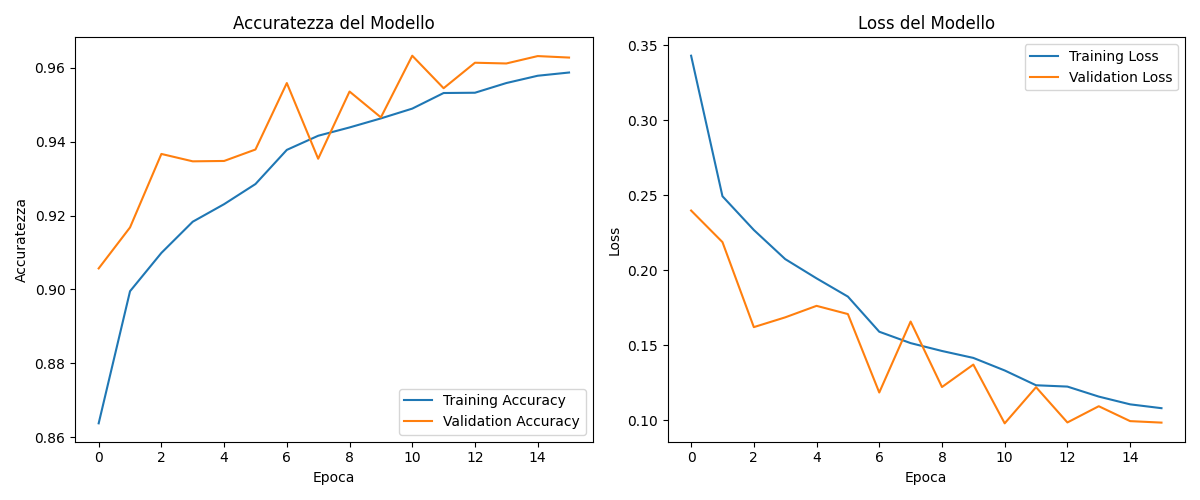

In [7]:
Image('training_history.png')

In [8]:
def evaluate_model(model, x_test, y_test, class_names):
    print("\nValutazione del modello sul set di test...")
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predizione')
    plt.ylabel('Valore Reale')
    plt.title('Matrice di Confusione')
    plt.savefig('confusion_matrix.png')
    plt.close()
    print("Matrice di confusione salvata in 'confusion_matrix.png'")
    print("\nReport di classificazione:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))
    report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv('classification_report.csv')
    print("Report di classificazione salvato in 'classification_report.csv'")
    return y_pred, y_true_classes, y_pred_classes

In [9]:
def visualize_incorrect_predictions(x_test, y_true_classes, y_pred_classes, class_names, n=20):
    print("Visualizzazione delle predizioni errate...")
    incorrect_indices = np.where(y_true_classes != y_pred_classes)[0]
    if len(incorrect_indices) == 0:
        print("Nessuna predizione errata trovata!")
        return
    n = min(n, len(incorrect_indices))
    plt.figure(figsize=(20, n))
    for i, idx in enumerate(incorrect_indices[:n]):
        plt.subplot(n // 4 + 1, 4, i + 1)
        plt.imshow(x_test[idx])
        plt.title(f"Vero: {class_names[y_true_classes[idx]]}\nPred: {class_names[y_pred_classes[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('incorrect_predictions.png')
    plt.close()
    print(f"Esempi di {n} predizioni errate salvate in 'incorrect_predictions.png'")

In [10]:
def analyze_class_activation_maps(model, x_test, y_true_classes, class_names, n=5):
    """
    Analizza le mappe di attivazione della classe per capire su quali parti
    dell'immagine il modello si sta concentrando per fare la predizione.
    """
    try:
        # Crea un modello che restituisce sia la predizione che l'ultima mappa di attivazione convoluzionale
        last_conv_layer_name = None
        for layer in reversed(model.layers):
            if isinstance(layer, layers.Conv2D):
                last_conv_layer_name = layer.name
                break

        if last_conv_layer_name is None:
            print("Nessun layer convoluzionale trovato nel modello.")
            return

        # Modello per estrarre le mappe di attivazione
        grad_model = tf.keras.models.Model(
            inputs=[model.inputs],
            outputs=[
                model.get_layer(last_conv_layer_name).output,
                model.output
            ]
        )

        # Seleziona alcune immagini
        selected_indices = np.random.choice(len(x_test), n, replace=False)

        plt.figure(figsize=(15, n * 3))
        for i, idx in enumerate(selected_indices):
            img = x_test[idx]
            img_array = np.expand_dims(img, axis=0)

            # Calcola le mappe di attivazione
            with tf.GradientTape() as tape:
                conv_outputs, predictions = grad_model(img_array)
                class_idx = y_true_classes[idx]
                loss = predictions[:, class_idx]

            # Estrai gli output dell'ultimo layer convoluzionale
            output = conv_outputs[0]

            # Crea una mappa di calore ponderata
            weights = tape.gradient(loss, conv_outputs)[0]
            cam = np.mean(output * weights[..., np.newaxis], axis=(0, 1))

            cam = np.maximum(cam, 0)  # ReLU
            heatmap = cam / np.max(cam)

            # Ridimensiona la mappa di calore alle dimensioni dell'immagine originale
            import cv2
            heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

            # Converti la mappa di calore in RGB
            heatmap = np.uint8(255 * heatmap)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

            # Sovrapponi la mappa di calore all'immagine originale
            superimposed_img = heatmap * 0.4 + img * 255
            superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

            # Visualizza l'immagine originale e la mappa di calore
            plt.subplot(n, 2, i * 2 + 1)
            plt.imshow(img)
            plt.title(f"Originale: {class_names[class_idx]}")
            plt.axis('off')

            plt.subplot(n, 2, i * 2 + 2)
            plt.imshow(superimposed_img)
            plt.title("Mappa di Attivazione")
            plt.axis('off')

        plt.tight_layout()
        plt.savefig('class_activation_maps.png')
        plt.close()
        print("Mappe di attivazione delle classi salvate in 'class_activation_maps.png'")
    except Exception as e:
        print(f"Errore durante la generazione delle mappe di attivazione: {e}")

In [11]:
y_pred, y_true_classes, y_pred_classes = evaluate_model(trained_model, x_test, y_test, class_names)
visualize_incorrect_predictions(x_test, y_true_classes, y_pred_classes, class_names)
analyze_class_activation_maps(trained_model, x_test, y_true_classes, class_names)


Valutazione del modello sul set di test...
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 70ms/step - accuracy: 0.9611 - loss: 0.1018
Test accuracy: 0.9619
Test loss: 0.0978
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step
Matrice di confusione salvata in 'confusion_matrix.png'

Report di classificazione:
              precision    recall  f1-score   support

     Veicolo       0.95      0.95      0.95      4000
     Animale       0.97      0.97      0.97      6000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Report di classificazione salvato in 'classification_report.csv'
Visualizzazione delle predizioni errate...
Esempi di 20 predizioni errate salvate in 'incorrect_predictions.png'
Errore durante la generazione delle mappe di attivazione: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [8,8,128] vs. [8,8,128,1] [Op:Mul] name: 


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


<Figure size 1500x1500 with 0 Axes>

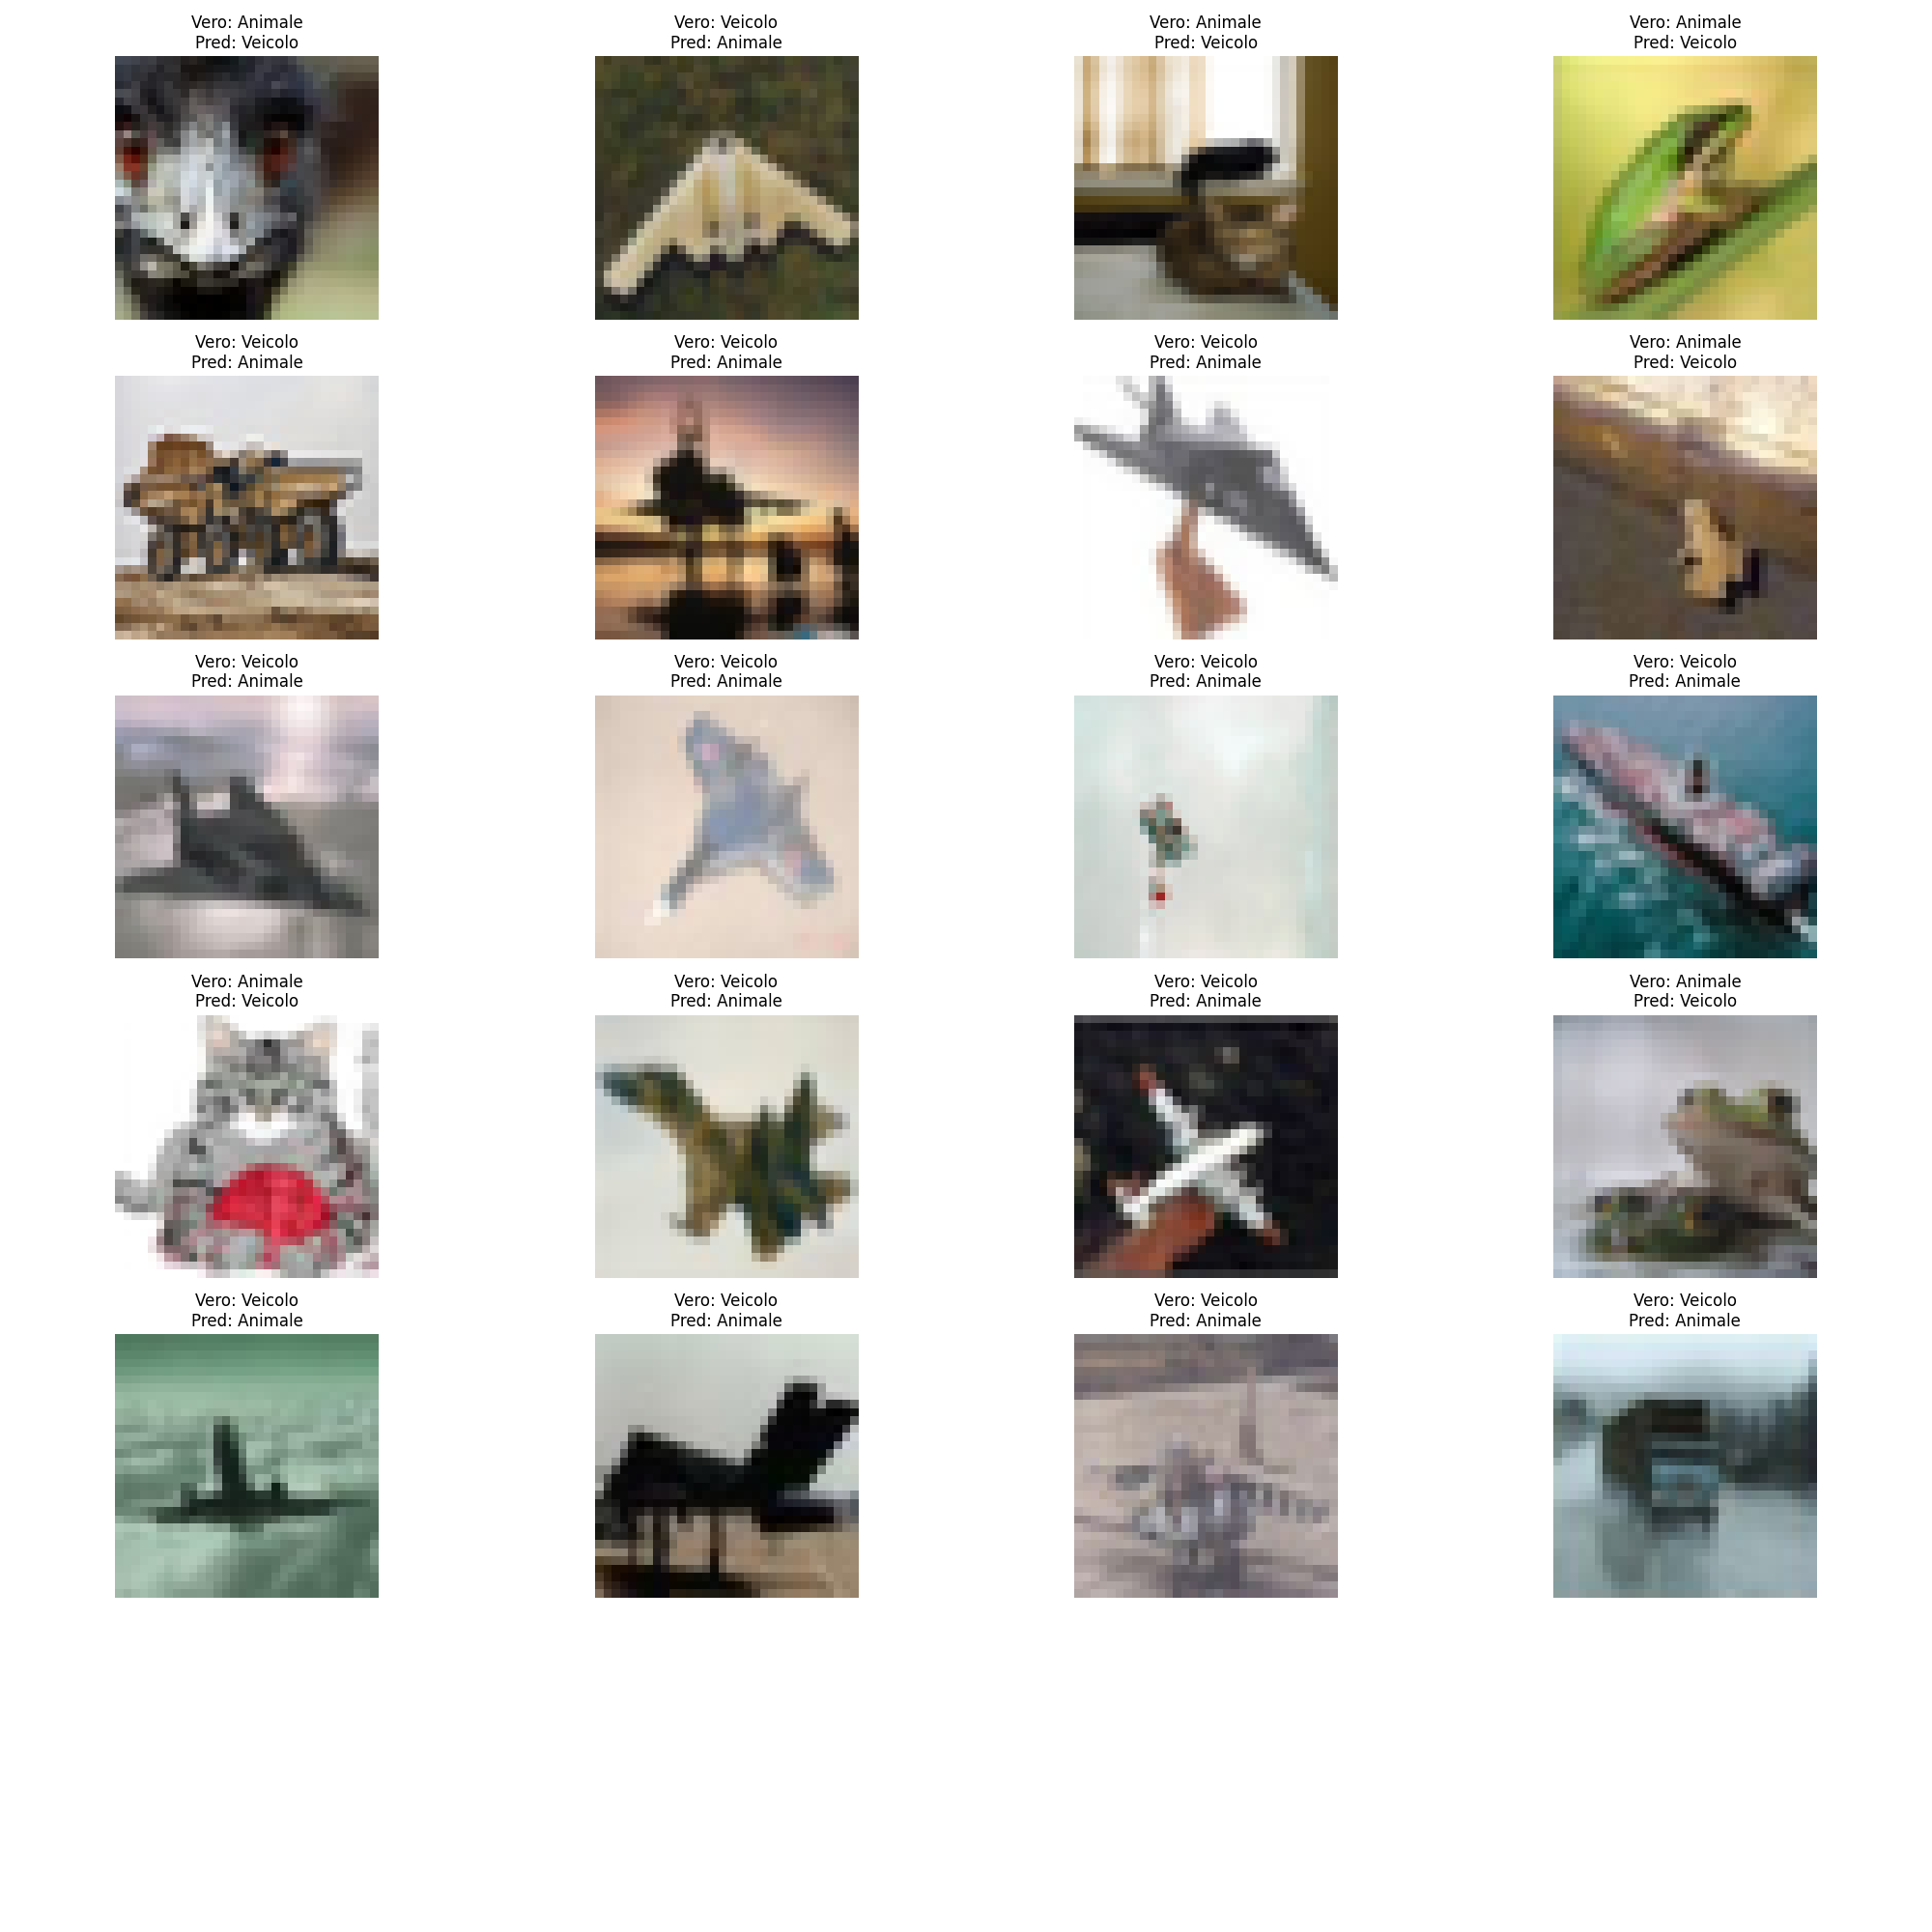

In [12]:
Image('class_activation_maps.png')
Image('incorrect_predictions.png')

In [15]:
trained_model.save('vehicle_animal_classifier_final.keras')
print("\nModello finale salvato come 'vehicle_animal_classifier_final.keras'")


Modello finale salvato come 'vehicle_animal_classifier_final.keras'


# 6. Sperimentazione: provare diverse architetture della CNN

In questa sezione puoi sperimentare facilmente con diverse configurazioni della CNN, modificando il numero di blocchi convoluzionali, i filtri, i dropout e i layer densi.
Questo permette di valutare l'impatto della complessità del modello sulle prestazioni, dimostrando la comprensione delle reti neurali convoluzionali e la capacità di adattarle a diversi scopi.

- Risultati modello "Piccola": Test accuracy = 0.9518, Test loss = 0.1190
Addestramento completato in 4259.31 secondi


- Risultati modello "Standard": Test accuracy = 0.9458, Test loss = 0.1300
Addestramento completato in 4259.31 secondi

- Risultati modello Grande: Test accuracy = 0.9585, Test loss = 0.1085
Addestramento completato in 11417.86 secondi


In [14]:

experiment_configs = [
    {"name": "Piccola", "conv_blocks": [(16, 0.1), (32, 0.2)], "dense_units": 64, "dense_dropout": 0.3},
    {"name": "Standard", "conv_blocks": [(32, 0.2), (64, 0.3), (128, 0.4)], "dense_units": 256, "dense_dropout": 0.5},
    {"name": "Grande", "conv_blocks": [(64, 0.3), (128, 0.4), (256, 0.5)], "dense_units": 512, "dense_dropout": 0.6},
]

for config in experiment_configs:
    print(f"\n--- Sperimentazione: Modello {config['name']} ---")
    model = create_cnn_model(conv_blocks=config["conv_blocks"], dense_units=config["dense_units"], dense_dropout=config["dense_dropout"])
    trained_model, history = train_model(model, train_generator, x_val, y_val, epochs=10)  # meno epoche per rapidità
    test_loss, test_acc = trained_model.evaluate(x_test, y_test, verbose=0)
    print(f"Risultati modello {config['name']}: Test accuracy = {test_acc:.4f}, Test loss = {test_loss:.4f}")


--- Sperimentazione: Modello Piccola ---
Creazione del modello CNN...


Model: "vehicle_animal_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,562 (580.32 KB)

 Trainable params: 148,242 (579.07 KB)

 Non-trainable params: 320 (1.25 KB)

Inizio addestramento del modello...
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8381 - loss: 0.3981

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 164s 127ms/step - accuracy: 0.8381 - loss: 0.3980 - val_accuracy: 0.8740 - val_loss: 0.3247 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8951 - loss: 0.2575

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 153s 122ms/step - accuracy: 0.8951 - loss: 0.2575 - val_accuracy: 0.9252 - val_loss: 0.1979 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9060 - loss: 0.2351

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 209s 128ms/step - accuracy: 0.9060 - loss: 0.2351 - val_accuracy: 0.9271 - val_loss: 0.1861 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9160 - loss: 0.2080

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 161s 129ms/step - accuracy: 0.9160 - loss: 0.2080 - val_accuracy: 0.9299 - val_loss: 0.1789 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9211 - loss: 0.1989

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 201s 127ms/step - accuracy: 0.9211 - loss: 0.1989 - val_accuracy: 0.9326 - val_loss: 0.1740 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 157s 125ms/step - accuracy: 0.9263 - loss: 0.1883 - val_accuracy: 0.9099 - val_loss: 0.2187 - learning_rate: 0.0010
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 203s 127ms/step - accuracy: 0.9256 - loss: 0.1884 - val_accuracy: 0.9145 - val_loss: 0.2094 - learning_rate: 0.0010
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 201s 126ms/step - accuracy: 0.9311 - loss: 0.1730 - val_accuracy: 0.9296 - val_loss: 0.1766 - learning_rate: 0.0010
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9376 - loss: 0.1650

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 161s 129ms/step - accuracy: 0.9376 - loss: 0.1650 - val_accuracy: 0.9487 - val_loss: 0.1298 - learning_rate: 5.0000e-04
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9374 - loss: 0.1596

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 203s 129ms/step - accuracy: 0.9374 - loss: 0.1596 - val_accuracy: 0.9517 - val_loss: 0.1244 - learning_rate: 5.0000e-04


Addestramento completato in 1812.89 secondi
Caricamento del miglior modello da: best_model_vehicle_animal.h5
Risultati modello Piccola: Test accuracy = 0.9518, Test loss = 0.1190

--- Sperimentazione: Modello Standard ---
Creazione del modello CNN...


Model: "vehicle_animal_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,02

 Total params: 814,882 (3.11 MB)

 Trainable params: 813,474 (3.10 MB)

 Non-trainable params: 1,408 (5.50 KB)

Inizio addestramento del modello...
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8280 - loss: 0.4743

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 402s 317ms/step - accuracy: 0.8280 - loss: 0.4742 - val_accuracy: 0.8828 - val_loss: 0.2912 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.8997 - loss: 0.2506

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 439s 315ms/step - accuracy: 0.8997 - loss: 0.2506 - val_accuracy: 0.9072 - val_loss: 0.2315 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9083 - loss: 0.2286

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 394s 316ms/step - accuracy: 0.9083 - loss: 0.2286 - val_accuracy: 0.9149 - val_loss: 0.2075 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9153 - loss: 0.2144

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 440s 314ms/step - accuracy: 0.9153 - loss: 0.2144 - val_accuracy: 0.9318 - val_loss: 0.1707 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9208 - loss: 0.2007

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 460s 328ms/step - accuracy: 0.9208 - loss: 0.2007 - val_accuracy: 0.9426 - val_loss: 0.1505 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 409s 327ms/step - accuracy: 0.9245 - loss: 0.1921 - val_accuracy: 0.9230 - val_loss: 0.1927 - learning_rate: 0.0010
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 422s 311ms/step - accuracy: 0.9308 - loss: 0.1797 - val_accuracy: 0.9362 - val_loss: 0.1712 - learning_rate: 0.0010
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 442s 311ms/step - accuracy: 0.9371 - loss: 0.1645 - val_accuracy: 0.9102 - val_loss: 0.2208 - learning_rate: 0.0010
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9423 - loss: 0.1487

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 461s 326ms/step - accuracy: 0.9423 - loss: 0.1487 - val_accuracy: 0.9480 - val_loss: 0.1330 - learning_rate: 5.0000e-04
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 389s 311ms/step - accuracy: 0.9448 - loss: 0.1401 - val_accuracy: 0.9464 - val_loss: 0.1384 - learning_rate: 5.0000e-04


Addestramento completato in 4259.31 secondi
Caricamento del miglior modello da: best_model_vehicle_animal.h5
Risultati modello Standard: Test accuracy = 0.9458, Test loss = 0.1300

--- Sperimentazione: Modello Grande ---
Creazione del modello CNN...


Model: "vehicle_animal_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 512)            │         2,04

 Total params: 3,249,730 (12.40 MB)

 Trainable params: 3,246,914 (12.39 MB)

 Non-trainable params: 2,816 (11.00 KB)

Inizio addestramento del modello...
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - accuracy: 0.8229 - loss: 0.5298

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1145s 910ms/step - accuracy: 0.8229 - loss: 0.5296 - val_accuracy: 0.8386 - val_loss: 0.3556 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.8909 - loss: 0.2728

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1132s 905ms/step - accuracy: 0.8909 - loss: 0.2728 - val_accuracy: 0.9174 - val_loss: 0.2081 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1113s 890ms/step - accuracy: 0.9040 - loss: 0.2436 - val_accuracy: 0.9046 - val_loss: 0.2355 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.9145 - loss: 0.2190

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1158s 887ms/step - accuracy: 0.9145 - loss: 0.2190 - val_accuracy: 0.9243 - val_loss: 0.1894 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1137s 909ms/step - accuracy: 0.9170 - loss: 0.2086 - val_accuracy: 0.9216 - val_loss: 0.1935 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1161s 909ms/step - accuracy: 0.9243 - loss: 0.1890 - val_accuracy: 0.8307 - val_loss: 0.4024 - learning_rate: 0.0010
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1145s 895ms/step - accuracy: 0.9298 - loss: 0.1802 - val_accuracy: 0.9017 - val_loss: 0.2568 - learning_rate: 0.0010
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.9408 - loss: 0.1565

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1144s 916ms/step - accuracy: 0.9408 - loss: 0.1565 - val_accuracy: 0.9539 - val_loss: 0.1202 - learning_rate: 5.0000e-04
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.9448 - loss: 0.1427

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1145s 916ms/step - accuracy: 0.9448 - loss: 0.1427 - val_accuracy: 0.9548 - val_loss: 0.1181 - learning_rate: 5.0000e-04
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.9469 - loss: 0.1390

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1138s 911ms/step - accuracy: 0.9469 - loss: 0.1390 - val_accuracy: 0.9580 - val_loss: 0.1111 - learning_rate: 5.0000e-04
Addestramento completato in 11417.86 secondi
Caricamento del miglior modello da: best_model_vehicle_animal.h5


Risultati modello Grande: Test accuracy = 0.9585, Test loss = 0.1085


# 7. Utilizzo del modello per classificare una nuova immagine

In questa sezione mostriamo come caricare il modello addestrato e utilizzarlo per riconoscere una nuova immagine. Puoi sostituire 'percorso_immagine' con il percorso di una tua immagine (32x32x3 o verrà ridimensionata automaticamente).

In [ ]:

from tensorflow.keras.preprocessing import image

def predict_new_image(model_path, image_path):
    class_names = ['Veicolo', 'Animale']
    print(f"\nClassificazione di una nuova immagine: {image_path}")
    # Carica il modello
    model = keras.models.load_model(model_path)
    # Carica e preprocessa l'immagine
    img = image.load_img(image_path, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array.astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    # Predizione
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    print(f"Predizione: {class_names[predicted_class]} (probabilità: {prediction[0][predicted_class]:.2f})")
    return class_names[predicted_class]

# Esempio di utilizzo:
# predict_new_image('vehicle_animal_classifier_final.keras', 'percorso_immagine.jpg')
# Sostituisci 'percorso_immagine.jpg' con il percorso reale della tua immagine.